# Preprocessing OASIS1

In [1]:
# IMPORTS
# DATA MANIPULATION
import pandas as pd
import numpy as np

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import set_config; set_config(display='diagram') # Visualize pipelines in HTML
import graphviz
from sklearn.tree import export_graphviz
from sklearn import tree

# MACHINE LEARNING
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb

/home/cynthias13w/.pyenv/versions/3.8.12/envs/memobrain/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Importing Data
oasis1_cs_path = '../raw_data/OASIS1/oasis_cross-sectional.csv'
oasis1 = pd.read_csv(oasis1_cs_path)

In [3]:
# Checking shape
oasis1.shape

(436, 12)

📜 <big> Note: </big>


**CDR;** Clinical Dementia Rating 

0= nondemented; 0.5 – very mild dementia; 1 = mild dementia; 2 = moderate dementia


**eTIV;** Estimated total intracranial volume (eTIV)

**nWBV** Normalized whole brain volume

**ASF;** Atlas scaling factor

In [4]:
oasis1.sample(20)

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
316,OAS1_0350_MR1,M,R,21,NaN,NaN,NaN,NaN,1577,0.869,1.113,NaN
372,OAS1_0410_MR1,F,R,23,NaN,NaN,NaN,NaN,1507,0.870,1.165,NaN
109,OAS1_0117_MR1,M,R,25,NaN,NaN,NaN,NaN,1759,0.783,0.998,NaN
432,OAS1_0353_MR2,M,R,22,NaN,NaN,NaN,NaN,1684,0.790,1.042,40.0
98,OAS1_0106_MR1,F,R,81,2.0,4.0,30.0,0.0,1230,0.717,1.427,NaN
414,OAS1_0456_MR1,M,R,61,5.0,2.0,30.0,0.0,1637,0.780,1.072,NaN
49,OAS1_0054_MR1,F,R,21,NaN,NaN,NaN,NaN,1567,0.848,1.120,NaN
93,OAS1_0101_MR1,M,R,29,NaN,NaN,NaN,NaN,1486,0.840,1.181,NaN
276,OAS1_0305_MR1,M,R,48,NaN,NaN,NaN,NaN,1454,0.850,1.207,NaN
68,OAS1_0073_MR1,F,R,69,2.0,4.0,21.0,1.0,1495,0.655,1.174,NaN


In [5]:
oasis1.isnull().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

## Data Cleaning

**We want to define a function that:**

1. Drops rows that have no values for CDR (prediction)
2. Fills empty values for socioeconomic status with a value
3. Replaces Male with 1 and Female with 0
4. Converts CDR from 4 unique values to 2 unique values so that we now have a binary classification problem
5. Drops columns Delay and Handedness

In [6]:
def clean_data(oasis1):
    """This function removes CDR rows containing NANs, 
    fills SES missing values with status 3,
    encodes Male/Female M/F to 1 and 0,
    and drops columns Delay and Hand."""
    
    oasis1.dropna(subset = ["CDR"], inplace=True) # removing the target
    oasis1['SES'].fillna(value=3, inplace=True) # Socioeconomic status 3 means that participants went to 'some college'
    # oasis1['M/F'].replace({'F':0, 'M':1}, inplace = True) # Replaces M with 1 and Female with 0
    oasis1.drop('Delay', inplace=True, axis=1)
    oasis1.drop('Hand', inplace=True, axis=1)
    
    return oasis1

In [7]:
clean_oasis1 = clean_data(oasis1)
clean_oasis1

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
411,OAS1_0453_MR1,F,70,1.0,4.0,29.0,0.5,1295,0.748,1.355
412,OAS1_0454_MR1,F,73,3.0,2.0,23.0,0.5,1536,0.730,1.142
413,OAS1_0455_MR1,F,61,2.0,4.0,28.0,0.0,1354,0.825,1.297
414,OAS1_0456_MR1,M,61,5.0,2.0,30.0,0.0,1637,0.780,1.072


### Testing my code

In [8]:
# Check shape again
oasis1.shape

(235, 10)

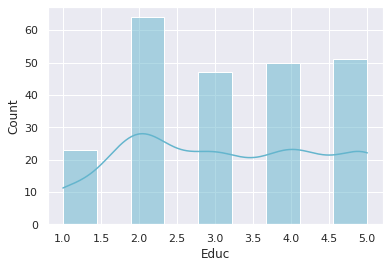

In [9]:
# Education is not normally distrbuted
sns.histplot(oasis1.Educ,kde = True, color = 'c');

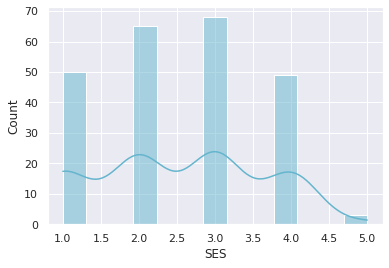

In [10]:
sns.histplot(oasis1.SES, kde = True, color = 'c');

In [11]:
# Check whether NANs are still here
oasis1.CDR.unique()

array([0. , 0.5, 1. , 2. ])

In [12]:
# Check SES column
oasis1.SES.unique()

array([3., 1., 2., 4., 5.])

In [13]:
# Check M/F column
oasis1['M/F']

0      F
1      F
2      F
8      M
9      F
      ..
411    F
412    F
413    F
414    M
415    F
Name: M/F, Length: 235, dtype: object

In [14]:
# def gender_encoding(i):
#     """This function returns 0 for F and 1 for M"""
#     return i.map({'F':0, 'M':1})

## Defining variables

In [15]:
X = clean_oasis1.drop(columns = ['ID','CDR']).reset_index(drop = True)
y = clean_oasis1['CDR'].reset_index(drop = True)

In [16]:
X

,M/F,Age,Educ,SES,MMSE,eTIV,nWBV,ASF
0,F,74,2.0,3.0,29.0,1344,0.743,1.306
1,F,55,4.0,1.0,29.0,1147,0.810,1.531
2,F,73,4.0,3.0,27.0,1454,0.708,1.207
3,M,74,5.0,2.0,30.0,1636,0.689,1.073
4,F,52,3.0,2.0,30.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...
230,F,70,1.0,4.0,29.0,1295,0.748,1.355
231,F,73,3.0,2.0,23.0,1536,0.730,1.142
232,F,61,2.0,4.0,28.0,1354,0.825,1.297
233,M,61,5.0,2.0,30.0,1637,0.780,1.072


In [17]:
# Holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 42)

In [18]:
X_train

,M/F,Age,Educ,SES,MMSE,eTIV,nWBV,ASF
126,M,70,5.0,1.0,30.0,1660,0.739,1.057
79,F,84,2.0,2.0,27.0,1390,0.727,1.263
5,F,81,5.0,2.0,30.0,1664,0.679,1.055
56,M,84,3.0,4.0,28.0,1483,0.697,1.183
120,F,74,5.0,2.0,30.0,1400,0.754,1.254
...,...,...,...,...,...,...,...,...
106,F,74,3.0,3.0,28.0,1614,0.697,1.087
14,F,58,5.0,1.0,30.0,1235,0.820,1.421
92,M,84,5.0,1.0,29.0,1707,0.731,1.028
179,M,86,1.0,4.0,15.0,1512,0.665,1.161


In [19]:
clean_oasis1.isnull().sum()

ID      0
M/F     0
Age     0
Educ    0
SES     0
MMSE    0
CDR     0
eTIV    0
nWBV    0
ASF     0
dtype: int64

## Preprocessing pipeline

📜 Note: columns **nWBV and ASF** already normalized
 
 According to visualizations in file 'Demographic_visual.ipynb', we decided to scale as follows:
 
**Columns to scale:**

Standard Scale: age

Robust Scale: eTIV, MMSE

MinMax Scale: Educ

In [20]:
class CustomColumnTransformer(ColumnTransformer):
    def transform(self, *args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())
    def fit_transform(self, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

In [21]:
class ColumnNameExtractorAfterImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, *_):
        return self

    def transform(self, X, *_):
        return pd.DataFrame(X, columns=self.columns)

In [22]:
# Transformer for numerical features

def numerical_transformer():
    """This function transforms all numerical features according to their respective scalers
    """
    standard_features = ['Age']
    robust_features = ['eTIV', 'MMSE']
    minmax_features = ['Educ']
    
    numeric_transformer = CustomColumnTransformer([
        ('standard_scaler', StandardScaler(), standard_features),
        ('robust_scaler', RobustScaler(), robust_features),
        ('minmax_scaler', MinMaxScaler(), minmax_features),
         ], remainder = 'passthrough')
    
    return numeric_transformer
numeric_transformer = numerical_transformer()
numeric_transformer

CustomColumnTransformer(remainder='passthrough',
                        transformers=[('standard_scaler', StandardScaler(),
                                       ['Age']),
                                      ('robust_scaler', RobustScaler(),
                                       ['eTIV', 'MMSE']),
                                      ('minmax_scaler', MinMaxScaler(),
                                       ['Educ'])])

In [23]:
standard_features = ['Age']
robust_features = ['eTIV', 'MMSE']
minmax_features = ['Educ']
nothing_to_scale = ['nWBV','ASF', 'SES']

In [24]:
numerical_features = standard_features + robust_features + minmax_features + nothing_to_scale
numerical_features

['Age', 'eTIV', 'MMSE', 'Educ', 'nWBV', 'ASF', 'SES']

In [25]:
def num_transformer():
    ses = ['SES']
    pipeline = Pipeline([
                    ("imputer", SimpleImputer(strategy = "median")),
                    ("column_name_extractor_after_imputer", ColumnNameExtractorAfterImputer(ses)),
                    ("scalers", numeric_transformer)
                ])
    return pipeline

num_transformer = num_transformer()

In [26]:
# Transformer for categorical features

binary_categorical_features = ['M/F']
def binary_categorical_transformer():
    """This function encodes all categorical features according to their respective encoder.
    """
    categorical_transformer = CustomColumnTransformer([
       ("ohe_binary", 
         OneHotEncoder(sparse = False,
                       drop = "if_binary", 
                       handle_unknown = "error"), 
         binary_categorical_features)
    ])
    return categorical_transformer
binary_category_transformer = binary_categorical_transformer()
binary_category_transformer

CustomColumnTransformer(transformers=[('ohe_binary',
                                       OneHotEncoder(drop='if_binary',
                                                     sparse=False),
                                       ['M/F'])])

## Parellel Transformation: Numerical + Categorical

In [27]:
def preprocessing():
    ses = ['SES']
    preprocessor = CustomColumnTransformer([
            ("num_transformer", num_transformer, numerical_features),
            ("cat_transformer", binary_category_transformer, binary_categorical_features)
            ], remainder = 'passthrough')
    return preprocessor

preprocessor = preprocessing()
preprocessor

CustomColumnTransformer(remainder='passthrough',
                        transformers=[('num_transformer',
                                       Pipeline(steps=[('imputer',
                                                        SimpleImputer(strategy='median')),
                                                       ('column_name_extractor_after_imputer',
                                                        ColumnNameExtractorAfterImputer(columns=['SES'])),
                                                       ('scalers',
                                                        CustomColumnTransformer(remainder='passthrough',
                                                                                transformers=[('standard_scaler',
                                                                                               StandardScaler(),
                                                                                               ['Age']),
                                                                                              ('robust_scaler',
                                                                                               RobustScaler(),
                                                                                               ['eTIV',
                                                                                                'MMSE']),
                                                                                              ('minmax_scaler',
                                                                                               MinMaxScaler(),
                                                                                               ['Educ'])]))]),
                                       ['Age', 'eTIV', 'MMSE', 'Educ', 'nWBV',
                                        'ASF', 'SES']),
                                      ('cat_transformer',
                                       CustomColumnTransformer(transformers=[('ohe_binary',
                                                                              OneHotEncoder(drop='if_binary',
                                                                                            sparse=False),
                                                                              ['M/F'])]),
                                       ['M/F'])])

In [28]:
# def fit_pipeline(X_train):
#     '''This function fits the pipeline to the input data
#     '''
#     pipeline = set_pipeline()
#     return pipeline.fit(X_train)

# fit_pipeline(X_train)

In [29]:
X_train

,M/F,Age,Educ,SES,MMSE,eTIV,nWBV,ASF
126,M,70,5.0,1.0,30.0,1660,0.739,1.057
79,F,84,2.0,2.0,27.0,1390,0.727,1.263
5,F,81,5.0,2.0,30.0,1664,0.679,1.055
56,M,84,3.0,4.0,28.0,1483,0.697,1.183
120,F,74,5.0,2.0,30.0,1400,0.754,1.254
...,...,...,...,...,...,...,...,...
106,F,74,3.0,3.0,28.0,1614,0.697,1.087
14,F,58,5.0,1.0,30.0,1235,0.820,1.421
92,M,84,5.0,1.0,29.0,1707,0.731,1.028
179,M,86,1.0,4.0,15.0,1512,0.665,1.161


In [30]:
preprocessor.fit_transform(X_train)

ValueError: Shape of passed values is (164, 7), indices imply (164, 1)

In [ ]:
def preproc_df():
    X_scaled = pd.DataFrame(preprocessor.fit_transform(X_train))
    return X_scaled
preproc_df()

In [ ]:
def preproc_df(X_train):
    """This function returns a scaled dataframe ready for processing
    """
    X_scaled = pd.DataFrame(preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out())
#     X_scaled.rename(columns={
#                                  '__M/F': 'M/F',
#                                  'remainder__SES': 'SES',
#                                  'remainder__nWBV': 'nWBV',
#                                  'remainder__ASF': 'ASF',
#                                  'standard_scaler__Age': 'Age',
#                                  'robust_scaler__eTIV': 'eTIV',
#                                  'robust_scaler__MMSE': 'MMSE',
#                                  'minmax_scaler__Educ': 'Educ'
    
#     }, inplace=True)
    
#     X_scaled = X_scaled[["M/F", "Age", "Educ", "SES", "MMSE", "eTIV", "nWBV", "ASF"]]
    return X_scaled
X_scaled
# X_train = preproc_df(X_train)
# X_test = preproc_df(X_test)

In [ ]:
X_test_scaled = pd.DataFrame(pipeline.transform(X_test), columns = set_pipeline().get_feature_names_out())

In [ ]:
# Length of y_test = 59
np.unique(y_test, return_counts = True)

# Length of X_test = 59
len(X_test)

In [ ]:
# Making a copy of X_scaled
X_train_trial = X_train.copy()
X_train_trial

# 🎰SVC

## SVC Linear

### Just a trial

In [ ]:
# Instantiating linear support vector classifier
model_svc = SVC(kernel = 'linear')

In [ ]:
# Fitting LinearSVC
model_svc.fit(X_train, y_train)

In [ ]:
# Prediction on X_test
y_pred_SVC = model_svc.predict(X_test)

In [ ]:
cm_svc = confusion_matrix(y_test, y_pred_SVC)
cm_svc

In [ ]:
baseline_recall_svc = recall_score(y_test, y_pred_SVC)
baseline_recall_svc

###   🤖  Grid Searching

In [ ]:
# Creating a parameter grid: map the parameter names to the values that should be searched in a dictionary
param_grid = {'C':np.arange(700,750,1),
              'gamma':[1,0.1,0.001,0.0001]}

# GridSearching
gridsearch_svc = GridSearchCV(model_svc, 
                          param_grid, n_jobs = -1, 
                          scoring = 'recall', cv = 5)

# Fitting gridsearch on X and y
gridsearch_svc.fit(X_train, y_train)

In [ ]:
# Best estimator obtained from grid searching
best_linear_svc = gridsearch_svc.best_estimator_
best_linear_svc

### Best SVC linear

In [ ]:
# Fitting the best estimator onto the train set
best_linear_svc.fit(X_train, y_train)

In [ ]:
# Predicting X_test
best_svc_pred = best_linear_svc.predict(X_test)

In [ ]:
# Confusion matrix
cm_svc = confusion_matrix(y_test, best_svc_pred)
cm_svc

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc,
                             display_labels=["Nondemented","Demented"])
disp.plot(cmap = 'viridis')
plt.grid(visible = None)
plt.show()

In [ ]:
# Recall score
recall_score(y_test, best_svc_pred)

## SVC Poly

###  🤖 Grid Searching

In [ ]:
# Creating a parameter grid: map the parameter names to the values that should be searched in a dictionary
param_grid = {'C':np.arange(1,50,1),
              'gamma':[1,0.1,0.001,0.0001],
             'degree': np.arange(1,10,1)}

# GridSearching
gridsearch_svc = GridSearchCV(SVC(kernel = 'poly'), 
                          param_grid, n_jobs = -1, 
                          scoring = 'recall', cv = 5)

# Fitting gridsearch on X and y
gridsearch_svc.fit(X_train, y_train)

In [ ]:
# Best estimator obtained from grid searching
best_poly_svc = gridsearch_svc.best_estimator_
best_poly_svc

### Best SVC Poly

In [ ]:
# Predicting X_test
best_poly_pred = best_poly_svc.predict(X_test)

In [ ]:
# Confusion matrix
cm_poly_svc = confusion_matrix(y_test, best_poly_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_poly_svc,
                             display_labels=['Demented','Nondemented'])
disp.plot(cmap = 'viridis')
plt.grid(visible = None)
plt.show()

In [ ]:
# Recall score
recall_score(y_test, best_poly_pred)

## SVC Rbf

### Grid Searching

In [ ]:
# Creating a parameter grid: map the parameter names to the values that should be searched in a dictionary
param_grid = {'C':np.arange(1,200,1),
              'gamma':[1,0.1,0.001,0.0001]}

# GridSearching
gridsearch_svc = GridSearchCV(SVC(kernel = 'rbf'), 
                          param_grid, n_jobs = -1, 
                          scoring = 'recall', cv = 5)

# Fitting gridsearch on X and y
gridsearch_svc.fit(X_train, y_train)

In [ ]:
# Best estimator obtained from grid searching
best_rbf_svc = gridsearch_svc.best_estimator_
best_rbf_svc

### Best SVC Rbf

In [ ]:
# Predicting X_test
best_rbf_pred = best_rbf_svc.predict(X_test)

In [ ]:
# Confusion matrix
cm_rbf_svc = confusion_matrix(y_test, best_rbf_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rbf_svc,
                             display_labels=['Demented','Nondemented'])
disp.plot(cmap = 'viridis')
plt.grid(visible = None)
plt.show()

In [ ]:
# Recall score
recall_score(y_test, best_rbf_pred)

#  🤹 K Neighbors Classifier

ELBOW METHOD

In [ ]:
# Instantiating KNeighborsClassifier
neigh = KNeighborsClassifier()

###  🤖 Grid Searching

In [ ]:
# Defining the parameter values that should be searched
k_range = list(range(1, 31))

# Creating a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

In [ ]:
# Performing a grid search
grid = GridSearchCV(neigh, 
                    param_grid, 
                    cv=10, 
                    scoring='recall')

In [ ]:
# Fitting grid on train set
grid.fit(X_train, y_train)

In [ ]:
best_neigh = grid.best_estimator_

### Best Neigh model

In [ ]:
# Fitting KNeighborsClassifier
best_neigh.fit(X_train, y_train)

In [ ]:
best_neigh_pred = best_neigh.predict(X_test)

In [ ]:
# Confusion matrix
cm_neigh = confusion_matrix(y_test, best_neigh_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_neigh,
                             display_labels=['Demented','Nondemented'])
disp.plot(cmap = 'viridis')
plt.grid(visible = None)
plt.show()

In [ ]:
recall_score(y_test, best_neigh_pred)

# Ensemble

## 🌳Decision Tree

### Trial (just to practice)

In [ ]:
np.unique(y_train, return_counts = True)

In [ ]:
# Instantiating Decision Tree
tree_clf = DecisionTreeClassifier(max_depth = 5)

In [ ]:
# Fitting decision tree
tree_clf.fit(X_train_trial,y_train)

In [ ]:
# Predicting X_test
prediction = tree_clf.predict(X_test)
prediction

In [ ]:
# Accuracy
recall_score(y_test, prediction)

In [ ]:
# Export model graph
export_graphviz(tree_clf, out_file="oasis1_tree.dot", 
                feature_names=X_train_trial.columns,
                class_names=['nondemented', 'demented'], 
                rounded=True,
                filled=True,
                rotate = True,
                fontname = 'futura')

# Import model graph
with open("oasis1_tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

### 🤖 Grid Searching 

In [ ]:
# Parameters to grid search
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1,10),
              'min_samples_split': range(2,10),
              'min_samples_leaf': range(2,10)
             #'max_features': range(0,len(X_train.columns),
              }

In [ ]:
# GridSearching
gridsearch = GridSearchCV(DecisionTreeClassifier(), 
                          parameters, n_jobs = -1, 
                          scoring = 'recall', cv = 5)

# Fitting gridsearch on X and y
gridsearch.fit(X_train, y_train)

In [ ]:
# Best score according to gridsearch
gridsearch.best_score_

In [ ]:
# Best parameters
gridsearch.best_params_

### 🌲 Best Tree

In [ ]:
# Instantiating best tree
best_tree = gridsearch.best_estimator_

# Fitting best tree
best_tree.fit(X_train, y_train)

In [ ]:
# Predictions
y_pred = best_tree.predict(X_test)
y_pred

In [ ]:
# Recall score
recall_score(y_test, y_pred)

In [ ]:
# Predictions on the test set
y_tree_pred = best_tree.predict(X_test)
y_tree_pred

In [ ]:
# Confusion Matrix
tree_cm = confusion_matrix(y_test, y_tree_pred)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=tree_cm,
                             display_labels=["nondemented","demented"])
disp.plot(cmap = 'plasma')

plt.grid(visible = False)
plt.show()

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()
# We want to capture all 23 people with dementia

In [ ]:
# Export model graph
export_graphviz(best_tree, out_file="best_tree.dot", 
                feature_names=X_train_trial.columns,
                class_names=['nondemented', 'demented'], 
                rounded=True,
                filled=True,
                rotate = True,
                fontname = 'futura')

# Import model graph
with open("best_tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

<big> Conclusion: </big>

y_train = 76 demented, 100 nondemented

y_pred = 61 demented, 115 nondemented

## Random Forest

### Grid Searching

In [ ]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 5, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

### Best Forest

In [ ]:
# Defining best estimator for random forest
best_rf = rf_random.best_estimator_

# Fitting best random forest
best_rf.fit(X_train, y_train)

# XGBoost

- Sequential method
- Reduce bias
- Best weak learners given more weight

In [ ]:
# Instantiating classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
recall_score(y_test, preds)

### Grid Searching

In [ ]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [ ]:
grid_cv = GridSearchCV(xgb_cl, 
                       param_grid, 
                       n_jobs=-1, 
                       cv=3, 
                       scoring="recall")

In [ ]:
best_xgb = grid_cv.best_estimator_

In [ ]:
best_xgb.fit(X_train, y_train)

In [ ]:
# Predict
best_xgb_pred = best_xgb.predict(X_test)

# Score
recall_score(y_test, best_xgb_pred)

# Exporting Data

In [ ]:
frames=[X_scaled, y]
frames

In [ ]:
preprocessed_oasis1 = pd.concat(frames, axis =1)

In [ ]:
preprocessed_oasis1.to_csv(r'~/code/mkvph0ch/memobrain/notebooks/preprocessed_oasis1.csv')

# Recall Scores

<big> <b> Model names </b> </big>

<big> <font color = 'steelblue'> SVC </color> </big>

Linear: best_linear_svc - 78.2


Polynomial: best_poly_svc - 69.6 
    

Rbf: best_rbf_svc - 82.6  


<big> <font color = 'steelblue'> K Neighbors Classifier </color> <big>

best_neigh - 65.0

<big> <font color = 'steelblue'> Decision Tree </color> </big>
    
best_tree - 78.3


# Evaluating OASIS2

## Importing Data

In [ ]:
oasis2_cs_path = '../raw_data/OASIS2/preprocessed_oasis2.csv'
oasis2 = pd.read_csv(oasis2_cs_path)

In [ ]:
oasis2

In [ ]:
X2 = oasis2.drop(columns = 'CDR')
y2 = oasis2['CDR']

In [ ]:
X_train2, X_test2, ytrain2, y_test2 = train_test_split(X2, y2, test_size=0.30, random_state=42)

## Evaluating